In [9]:
import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit, CrabSpectrum
from gammapy.spectrum.models import SpectralModel
from scipy import stats
from tqdm import tqdm

from gammapy.spectrum import CountsPredictor

import emcee

from utils import load_spectrum_observations, Log10Parabola

from scipy.stats import poisson
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.optimize import minimize
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [10]:
tels = ['fact', 'magic', 'fermi', 'hess', 'veritas']

I plot the single fit results for the $\beta$ parameter including the estimated standard deviations from the output in the yaml files. This looks just like on would expect and totally fits the countour plots in the paper.


In [11]:
N = 70
stats.poisson.pmf(k=N, mu=N), stats.truncnorm.pdf(N, a=0, b=np.inf, loc=N, scale=10)

(0.04762599171586798, 0.07978845608028654)

In [32]:
def model_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value


def ln_likelihood(theta, n_on, n_off, alpha):
    mu_sig, mu_bkg = theta
    with np.errstate(divide='ignore', invalid='ignore'):
        a = n_on * np.log(mu_sig + alpha*mu_bkg)
        b = n_off * np.log(mu_bkg)
    return -(a + b - mu_sig - (alpha + 1)*mu_bkg)
    

def ln_prior(theta, alpha, n_off):
    '''
    Uninformative poisson prior as far as I know. 
    
    See https://en.wikipedia.org/wiki/Jeffreys_prior
    '''
    mu_sig, mu_bkg = theta
    with np.errstate(divide='ignore', invalid='ignore'):
#         m = np.sqrt(alpha) / np.sqrt(mu_bkg * (alpha*mu_bkg + mu_sig))
#         print('-----')
#         print(n_off, mu_bkg, stats.truncnorm.pdf(mu_bkg, a=0, b=np.inf, loc=n_off, scale=2*np.sqrt(n_off + 1)))
#         print('-----') # 2*np.sqrt(n_off)
        m = stats.truncnorm.pdf(mu_bkg, a=0, b=np.inf, loc=n_off, scale=2.5)
#         m = stats.poisson.pmf(k=mu_bkg, mu=n_off+0.05)
#         print(mu_sig, mu_bkg, mu_bkg * (alpha*mu_bkg + mu_sig), m)
        m = np.log(m)
#         m = np.zeros_like(mu_sig)
        m[mu_sig < 0] = np.inf
        m[mu_bkg < 0] = np.inf
#         print(m)

#     return np.where(mu_sig >= 0, np.log(np.sqrt(1/(mu_sig))), -np.inf) # jeffreys prior would be nice. but how?
    return m


def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = ln_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta, alpha, n_off)
        prob = prob + lp
    
    return np.where(np.isfinite(prob), prob, 0)


def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]



def model_probability(theta, observations, return_posterior=False, fit_range=None):
    amplitude, alpha, beta = theta[0:3]
#     if (alpha < 0) or ( beta < 0):
#         return -np.inf
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    obs_probabilities = []
    start = 3
    for obs in observations:
        mu_sig = model_prediction(model, obs)
        
        end = start + len(mu_sig) 
        mu_bkg = theta[start:end]
        start = end
        
        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
        obs_alpha=obs.alpha
        if fit_range is not None:
            bins = obs.on_vector.energy.bins
            mu_sig, mu_bkg, n_on, n_off, obs_alpha = apply_range(mu_sig, mu_bkg, n_on, n_off, obs_alpha, bins=bins, fit_range=fit_range)

        prob = ln_prob((mu_sig, mu_bkg), n_on, n_off, obs_alpha, return_posterior=return_posterior).sum()            

        obs_probabilities.append(prob)
    return -sum(obs_probabilities)

In [33]:
ln_likelihood(theta=(np.array([16, 15, 10, 20]), np.array([1, 4, 3, 2])), n_on=1, n_off=0, alpha=0.2)

array([14.41498876, 17.03999006, 11.239146  , 19.3844651 ])

In [34]:
obs_list = load_spectrum_observations('joint')
fit_range = [0.08, 30] * u.TeV

params = np.array([3.8, 2.3, 0.4])
# mu_bs = [np.random.poisson(obs.background_vector.data.data.value.astype(np.int) + 1) for obs in obs_list]
mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
theta = np.append(params, mu_bs)
model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range)

4179.200643785046

In [35]:
N = 25
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
#     t1 = [3.8, alpha, beta]
#     tb = np.random.poisson(obs.background_vector.data.data.value.astype(np.int))
    params = np.array([3.8, alpha, beta])
    theta = np.append(params, mu_bs)
    zs.append(model_probability(theta, obs_list, fit_range=fit_range))
    zs_post.append(model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range))

zs = np.array(zs)
zs_post = np.array(zs_post)


625it [00:07, 79.72it/s]


Text(0, 0.5, 'beta')

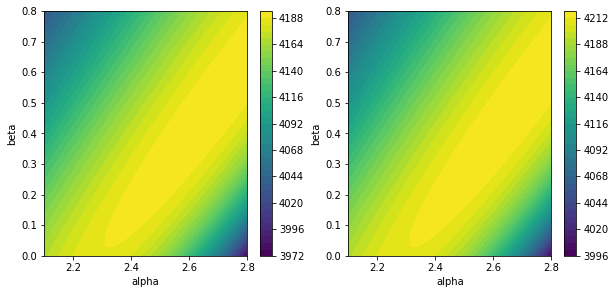

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=40)
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), levels=40)
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [31]:
# from scipy.optimize import minimize
# # x0 = np.append([3.8, 2.6, 0.4], )
# params = np.array([3.8, 2.4, 0.4])
# theta = np.append(params, mu_bs)
# result = minimize(lambda *x: -model_probability(*x), x0=theta, args=(obs_list, True, fit_range))
# result

In [289]:
ndim, nwalkers = len(theta), 2*len(theta)
print(ndim, nwalkers)
params = np.array([4, 2.4, 0.4])
mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
theta = np.append(params, mu_bs)

pos = np.array([theta + 0.05 * np.random.randn(ndim) for i in range(nwalkers)])
# print(pos)
sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, False, fit_range), threads=2)
sampler_output = sampler.run_mcmc(pos, 150, progress=True)

61 122


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 150/150 [02:59<00:00,  1.13s/it]


Number of params/dims: 61
shape of samples: (122, 150, 61)
0
1
2
3
4
5
6


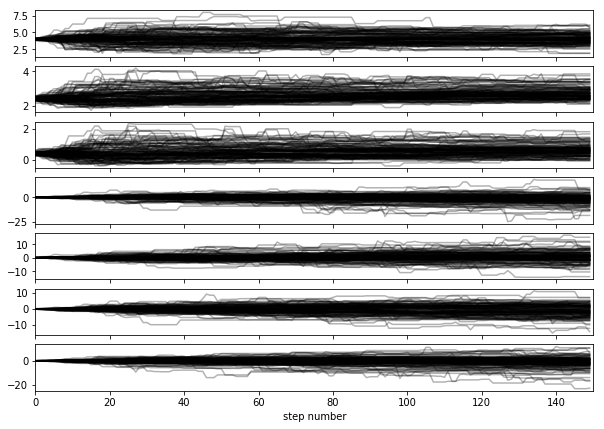

In [290]:
print(f'Number of params/dims: {ndim}')
print(f'shape of samples: {sampler.chain.shape}')
N = 7
fig, axes = plt.subplots(N, figsize=(10, 7), sharex=True)
# labels = ["amplitude", "alpha", "beta"]
for i in range(N):
    print(i)
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, len(sampler.chain[0]))
#     ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [38]:
import corner
N = 3
fig = corner.corner(sampler.chain[:, 50:, :N].reshape([-1, N]), labels=["$amplitude$", "$\\alpha$", "$\\beta$"],)

NameError: name 'sampler' is not defined

In [37]:
from IPython.display import display, Math

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, 50:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
joint_model = Log10Parabola(
    amplitude=3.78 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.49 * u.Unit(''),
    beta=0.22 * u.Unit(''),
)
joint_model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='silver')

r = np.median(sampler.chain[:, 50:, :3], axis=(0, 1))
print(r)
fitted_model = Log10Parabola(
    amplitude=r[0] * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=r[1] * u.Unit(''),
    beta=r[2] * u.Unit(''),
)
fitted_model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='crimson')

CrabSpectrum(reference='meyer').model.plot(energy_range=[0.3, 30]*u.TeV, energy_power=2, color='black', ls=':')

NameError: name 'sampler' is not defined